用 batchnormalize

In [1]:
from numpy import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import os

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import plot_model

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
X = load('./data/input_Female_gray10.npy')
Y = load('./data/output_Female_gray10.npy')

In [3]:
#get all class
YawDD = os.listdir("./Female")
classes = []
for item in YawDD:
    if item == ".DS_Store" or item == ".ipynb_checkpoints":
        pass
    else:
        classes.append(item)

In [4]:
seq_len = 10
#convert dimension of X to 1D 
X = X.reshape(X.shape[0] ,seq_len, -1)
features_len = X.shape[2] #shape of X: (number of videos, 10, 4096)

In [5]:
X.shape

(141, 10, 4096)

In [6]:
#define encoder
inputs = Input(shape=(seq_len,features_len))
encoded_X = SimpleRNN(200, activation='relu')(inputs)
encoded_X = Dense(100)(encoded_X)
encoded_X = Dense(64)(encoded_X)


#define decoder
decoded_X = RepeatVector(seq_len)(encoded_X)
decoded_X = Dense(64)(decoded_X)
decoded_X = Dense(100)(decoded_X)
decoded_X = SimpleRNN(200, activation='relu', return_sequences=True)(decoded_X)
decoded_X = TimeDistributed(Dense(features_len))(decoded_X)

AE = Model(inputs=inputs, outputs=decoded_X)
AE.compile(optimizer='adam', loss='mse')

#get encoder
Encoder = Model(inputs=inputs, outputs=encoded_X)

In [7]:
AE.summary()
# tf.keras.utils.plot_model(model, to_file='Model1.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 4096)]        0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200)               859400    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 64)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 64)            4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10, 100)           6500  

In [13]:
# plot_model(AE, to_file='AE_flowchart.png', show_shapes=True)

In [14]:
history = AE.fit(X, X, epochs=400, batch_size=8, verbose=1)

Epoch 1/400
18/18 [==============================] - 0s 10ms/step - loss: 8583.0342
Epoch 2/400
18/18 [==============================] - 0s 9ms/step - loss: 2222.5166
Epoch 3/400
18/18 [==============================] - 0s 9ms/step - loss: 2077.6995
Epoch 4/400
18/18 [==============================] - 0s 9ms/step - loss: 2011.7041
Epoch 5/400
18/18 [==============================] - 0s 9ms/step - loss: 1932.4413
Epoch 6/400
18/18 [==============================] - 0s 9ms/step - loss: 1833.1539
Epoch 7/400
18/18 [==============================] - 0s 9ms/step - loss: 1701.9562
Epoch 8/400
18/18 [==============================] - 0s 9ms/step - loss: 1633.3340
Epoch 9/400
18/18 [==============================] - 0s 9ms/step - loss: 1594.0317
Epoch 10/400
18/18 [==============================] - 0s 9ms/step - loss: 1557.4417
Epoch 11/400
18/18 [==============================] - 0s 9ms/step - loss: 1499.7944
Epoch 12/400
18/18 [==============================] - 0s 9ms/step - loss: 1464.2465


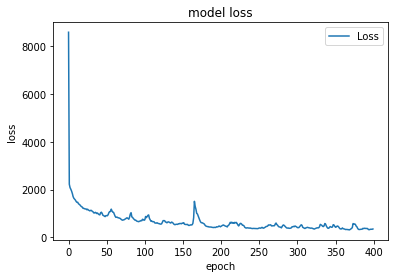

In [15]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='best')
plt.show()

In [16]:
encoded_pred = Encoder.predict(X)
               
# dimension:200->2
pca = PCA(n_components=2)

# PCA dimensionality reduction
X_pca = pca.fit_transform(encoded_pred)

# generate PCA dataframe
X_pca_frame = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2'])

print('PCA1 and PCA2:', pca.explained_variance_ratio_)

PCA1 and PCA2: [0.14511779 0.12109652]


In [17]:
#one-hot to integer
Y = np.array([np.where(r==1)[0][0] for r in Y])

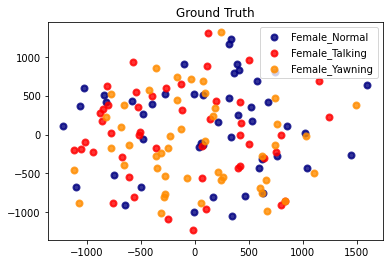

In [18]:
plt.figure()
colors = ['navy', 'red', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], np.array(classes)):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Ground Truth')
plt.show()

calinski_harabaz_score with k=3 is 109.14983724703575


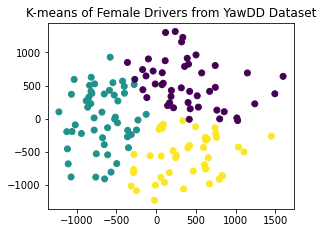

In [19]:
#plot K-Means
d = {}
fig_reduced_data = plt.figure(figsize=(12, 12)) #畫圖之前先設置figure，此函数=設置一塊自定義大小的畫布讓之後的圖形印在這塊畫布上
for k in range(3, 4):
    est = KMeans(n_clusters=k, random_state=111)
    y_pred = est.fit_predict(X_pca) #作用到降維後的數據上

    # X_pca_frame：表示要cluster的樣本數據，一般如（samples，features）的格式。y_pred：即cluster後得到的label，如（samples，）的格式
    calinski_harabaz_score = metrics.calinski_harabasz_score(X_pca_frame, y_pred)  
    d.update({k: calinski_harabaz_score})
    print('calinski_harabaz_score with k={0} is {1}'.format(k, calinski_harabaz_score))  # CH score的数值越大越好
    #生成2D圖，每個樣本點的坐標分别是兩個主成分的值
    ax = plt.subplot(4, 3, k-1) #將設置的畫布大小分成幾個部分，表示4(row)x3(col),k-4表示選擇圖形輸出的區域在第k-1塊，參數必須在“rowXcol”範圍
    ax.scatter(X_pca_frame.pca_1, X_pca_frame.pca_2, c=y_pred)  # pca_1、pca_2為輸入數據，c表示顏色序列

    plt.title('K-means of Female Drivers from YawDD Dataset')
    plt.tight_layout()
    plt.show()

In [20]:
X_pca_frame['class'] = y_pred
X_pca_frame = X_pca_frame.sort_values(by='class')

In [21]:
X_pca_frame

,pca_1,pca_2,class
0,573.122375,691.781799,0
108,170.037033,242.680756,0
32,672.674866,414.349976,0
72,-127.431763,646.275635,0
35,530.995117,177.041367,0
...,...,...,...
30,52.930401,-113.343513,2
111,606.530396,-691.774048,2
113,212.206894,-479.258270,2
96,256.329712,-551.299072,2


In [22]:
X_pca_frame.value_counts('class')

class
1    51
0    46
2    44
dtype: int64

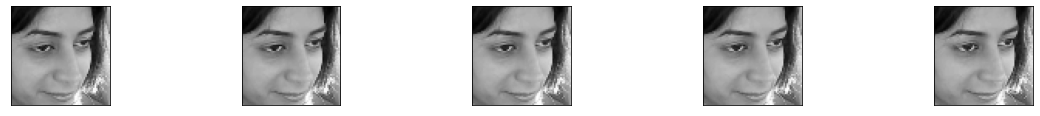

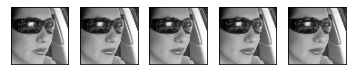

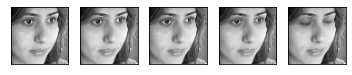

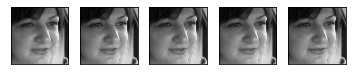

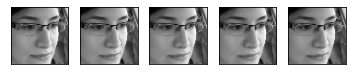

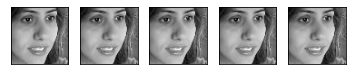

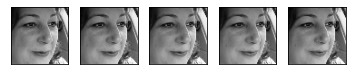

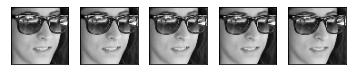

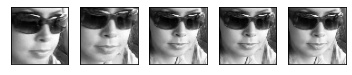

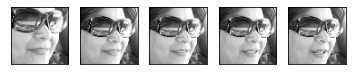

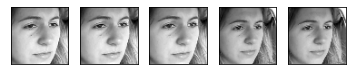

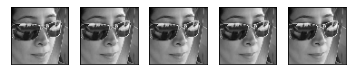

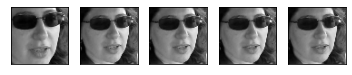

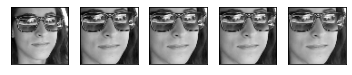

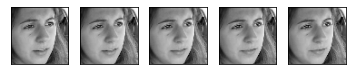

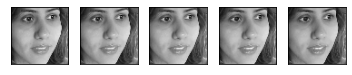

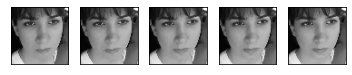

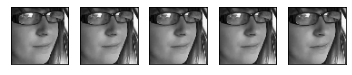

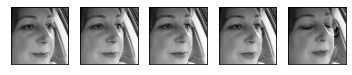

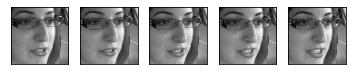

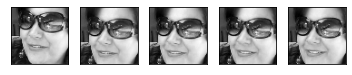

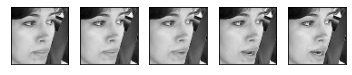

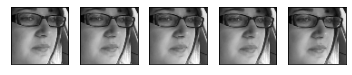

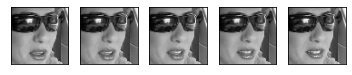

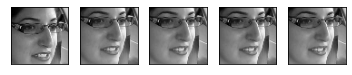

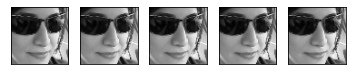

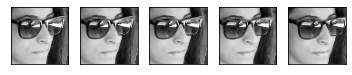

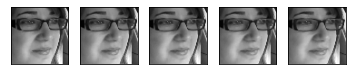

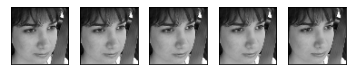

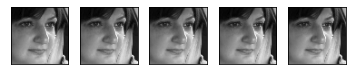

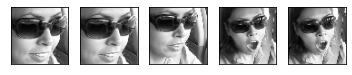

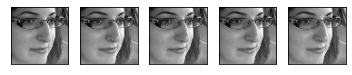

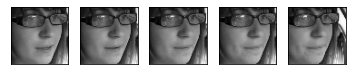

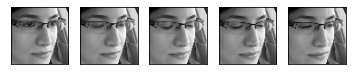

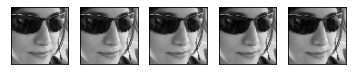

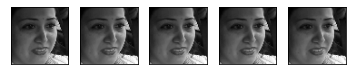

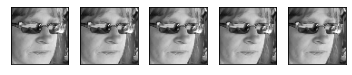

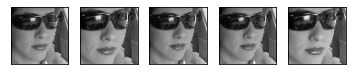

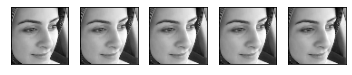

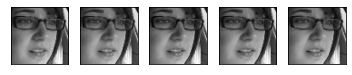

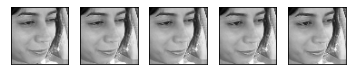

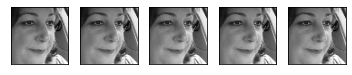

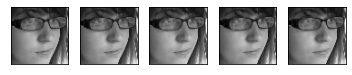

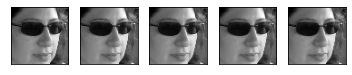

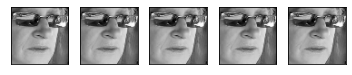

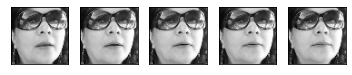

In [23]:
n = 5  #how many digits we will display

plt.figure(figsize=(20, 4))
for x in X_pca_frame.index:
    if X_pca_frame['class'][x] == 0:
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(X[x][i+4].reshape(64,64), cmap=plt.get_cmap('gray'))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        plt.show()

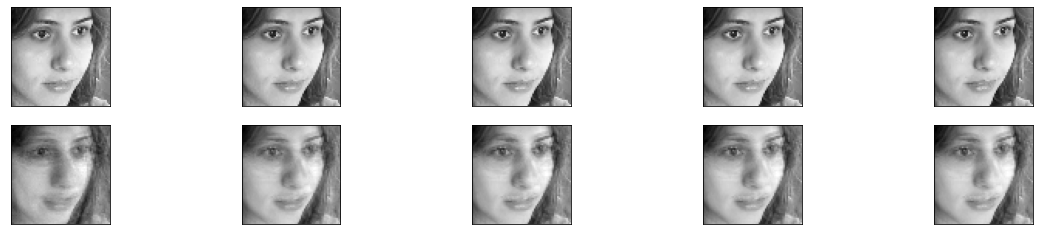

In [25]:
#compare original frames to reconstructed frames
decoded_imgs = AE.predict(X)
decoded_imgs_int = decoded_imgs.astype(np.int32)#plt沒辦法畫浮點數
n = 5  #how many digits we will display

plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[32][i].reshape(64,64), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_int[32][i].reshape(64,64), cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()